In [5]:
import mne
from pathlib import Path
data_path = r"data\konrad-real_movement\KONRAD-1_sciskanie_run1_20251202_194514_raw.fif"
recording_name = Path(data_path).stem
is_real_movement = "real" in data_path.lower()
recording_type = "real_movement" if is_real_movement else "motor_imagery"

raw = mne.io.read_raw_fif(data_path, preload=True)
eeg_channels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]
raw.pick(picks=eeg_channels)
raw.resample(sfreq=250)
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
raw.notch_filter(freqs=[50.0])

konrad_mapping = {
    'A1': 'Cz',
    'A2': 'FCz',
    'A3': 'CP1',
    'A4': 'FC1',
    'A5': 'C1',
    'A6': 'CP3',
    'A7': 'C3',
    'A8': 'FC3',
    'A9': 'C4',
    'A10': 'FC4',
    'A11': 'Pz',
    'A12': 'CP2',
    'A13': 'CP4',
    'A14': 'C2',    
    'A15': 'CPz',
    'A16': 'FC2'
}

raw.rename_channels(konrad_mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

all_events, all_events_id = mne.events_from_annotations(raw)
print(all_events_id)
all_events_id = {"relax": 1, "left_hand": 2, "right_hand": 3, "both_hands": 4, "both_feets": 5}

task_margin = 1.0 # event is when cue is shown
task_duration = 5.0
task_end = task_margin + task_duration
epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=all_events_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True
)



Opening raw data file data\konrad-real_movement\KONRAD-1_sciskanie_run1_20251202_194514_raw.fif...
Isotrak not found
    Range : 0 ... 962559 =      0.000 ...   470.000 secs
Ready.
Reading 0 ... 962559  =      0.000 ...   470.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windo

Using matplotlib as 2D backend.


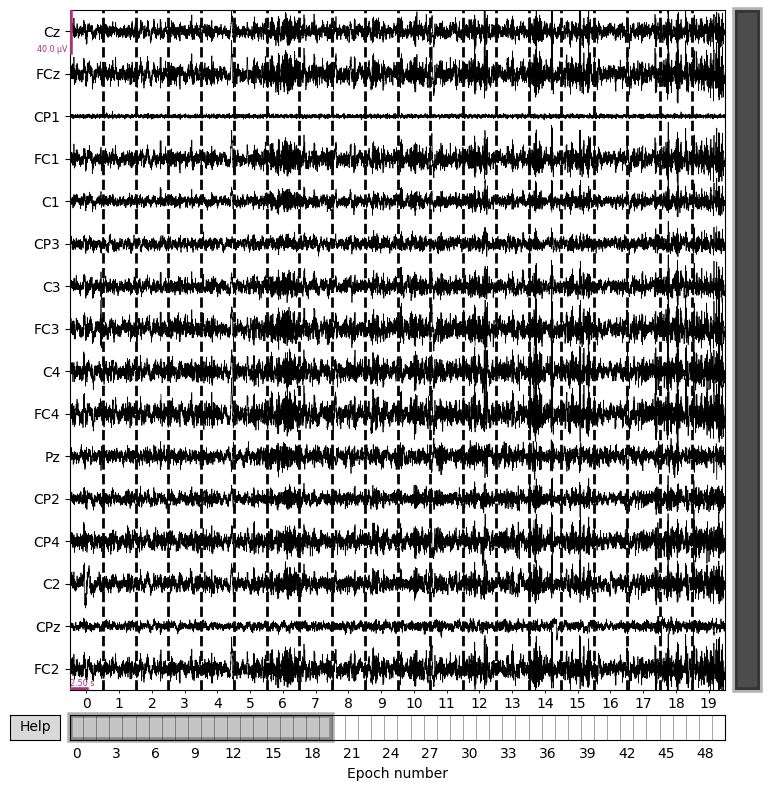

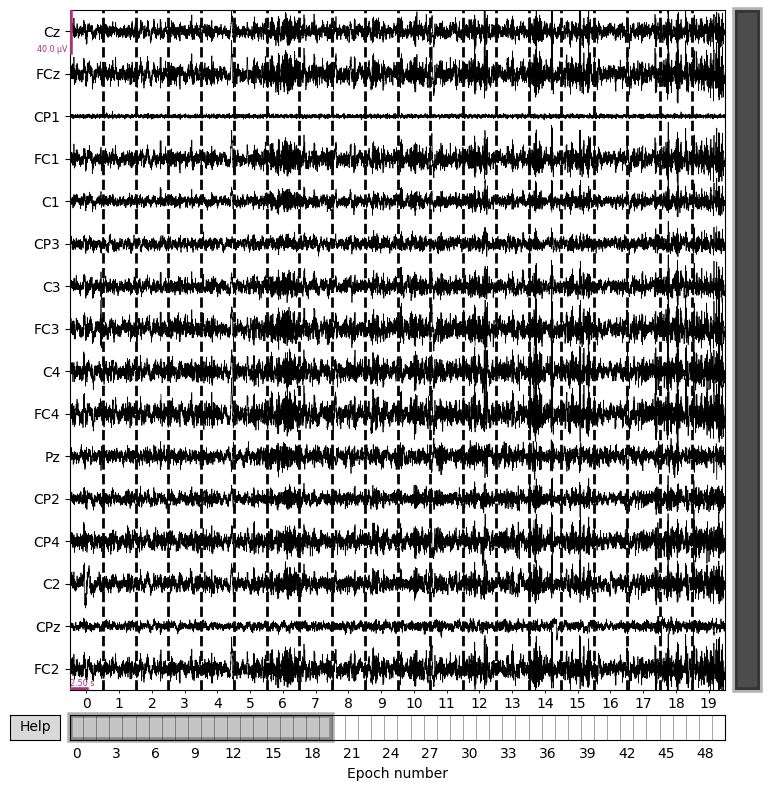

In [6]:
epochs.plot()

In [ ]:
import os
import numpy as np
import mne
from moabb.datasets.base import BaseDataset

class BrainBotDataset(BaseDataset):
    def __init__(self, data_dir, subjects, events, interval, data_names, sessions_per_subject):
        """
        Parameters
        ----------
        data_dir : str
            Path to the directory containing the data files.
        subjects : list
            List of subject identifiers.
        events : dict
            Dictionary mapping event names to event IDs.
        interval : list
            Time interval for epochs.
        data_names : dict
            Dictionary mapping subject identifiers to their corresponding data file names (can be multiple runs).
        sessions_per_subject : int
            Number of sessions per subject.
        """
        super().__init__(
            subjects=subjects,
            sessions_per_subject=sessions_per_subject,
            events=events,
            code="BrainBot",
            interval=interval,
            paradigm="imagery",
        )
        self.data_dir = data_dir
        self.data_names = data_names

    def data_path(self, subject, path=None, force_update=False, update_path=None, verbose=None):
        base = self.data_dir
        filenames = self.data_names[subject]
        epochs_files = [os.path.join(base, fname) for fname in filenames]
        return epochs_files

    def _get_single_subject_data(self, subject):
        paths = self.data_path(subject)
        sessions = {"0": {}} # sessions->runs->raw
        for i, path in enumerate(paths):
            epochs = mne.read_epochs(path, preload=True)
            data = epochs.get_data()
            n_epochs, n_ch, n_times = data.shape
            data_flat = data.transpose(1, 0, 2).reshape(n_ch, n_epochs * n_times)

            # create stim channel for moabb compatibility
            stim = np.zeros(n_epochs * n_times, dtype=int)
            for i, ev in enumerate(epochs.events):
                sample = i * n_times
                stim[sample] = int(ev[2])
            data_with_stim = np.vstack([data_flat, stim])

            sfreq = epochs.info['sfreq']
            ch_names = epochs.ch_names + ['stim']
            ch_types = ['eeg'] * n_ch + ['stim']
            info = mne.create_info(ch_names, sfreq, ch_types)
            raw = mne.io.RawArray(data_with_stim, info)
            sessions["0"][str(i)] = raw
        
        return sessions

dataset = BrainBotDataset(
    data_dir="data/processed/",
    subjects=[0], # 0 - konrad, 1 - hania, 2 - mati
    events=epochs.event_id,
    interval=[0.0, 2.0],
    data_names={
        0: [
            "KONRAD-1_sciskanie_run1_20251202_194514_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-2_sciskanie_run1_20251202_203846_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-3_sciskanie+ruszanie_run1_20251202_204816_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-4_ruszanie_run1_20251202_205706_raw_cropped_epochs_splitted_segment=2.0-step=1.0-epo.fif",
        ],
        1: [
            'hania_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif', # X: repeated to have 3 sessions      
        ],
        2: [
            'mati_test_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_2_squeezing_ball_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_3_lifting_fingers_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
        ],
    },
    sessions_per_subject=1,
)

The dataset class name 'BrainBotDataset' must be an abbreviation of its code 'BrainBot'. See moabb.datasets.base.is_abbrev for more information.


Renamed events: {'relax': 1, 'left_hand': 2, 'right_hand': 3, 'both_hands': 4, 'both_feets': 5}


In [10]:
from moabb.datasets import BNCI2014_001, PhysionetMI, Schirrmeister2017, Zhou2016
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

import moabb

moabb.set_log_level('ERROR')
mne.set_log_level('ERROR')

datasets = [dataset]
paradigm = LeftRightImagery() #MotorImagery(n_classes=5)

# Base classifiers and preprocessing
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipelines = {}
# Keep original pipelines for reference
pipelines['CSP + SVM'] = make_pipeline(csp, svm)
pipelines['CSP + LDA'] = make_pipeline(CSP(n_components=8), LinearDiscriminantAnalysis())

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# TGSP (Riemannian) pipeline
pipelines['TGSP + SVM'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), SVC(kernel="linear", probability=True))

# Calibrate SVM (wrap OneVsRestClassifier). Calibration improves predict_proba quality for voting/stacking
calibrated_svm = CalibratedClassifierCV(estimator=OneVsRestClassifier(SVC(kernel='rbf', probability=True)), cv=3)
pipelines['CSP + SVM (Cal)'] = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), calibrated_svm)
pipelines['TGSP + SVM (Cal)'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), CalibratedClassifierCV(estimator=SVC(kernel="linear", probability=True), cv=3))

# Build explicit ordered list of base estimators for ensembles
base_estimators = [
    ('csp_svm_cal', pipelines['CSP + SVM (Cal)']),
    ('csp_lda', pipelines['CSP + LDA']),
    ('tgsp_svm_cal', pipelines['TGSP + SVM (Cal)']),
]

# Weighted voting: favor the stronger models
voting = VotingClassifier(estimators=base_estimators, voting='soft', weights=[1, 2, 2])
pipelines['Ensemble (Weighted)'] = voting

# Stacking with a regularized meta-learner (smaller C => stronger regularization)
stacking = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(C=0.1, max_iter=1000), cv=5, stack_method='predict_proba')
pipelines['Stacking (All+RegLR)'] = stacking

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=True)
results = evaluation.process(pipelines)

BrainBot-WithinSession:   0%|          | 0/1 [00:00<?, ?it/s]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 80 events (all good), 0 – 2 s (baseline off), ~4.9 MiB, data loaded,
 'left_hand': 40
 'right_hand': 40>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 76 events (all good), 0 – 2 s (baseline off), ~4.7 MiB, data loaded,
 'left_hand': 36
 'right_hand': 40>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 72 events (all good), 0 – 2 s (baseline off), ~4.4 MiB, data loaded,
 'left_hand': 36
 'right_hand': 36>
  warn(f"warnEpochs {epochs}")


No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession: 100%|██████████| 1/1 [00:20<00:00, 20.37s/it]


In [ ]:
print(results)
print(dataset.get_data())

      score      time  samples subject session  channels  n_sessions  \
0  0.865036  0.456903    228.0       0       0        16           1   
1  0.819453  0.143406    228.0       0       0        16           1   
2  0.752329  0.153559    228.0       0       0        16           1   
3  0.889101  0.171813    228.0       0       0        16           1   
4  0.885738  0.141020    228.0       0       0        16           1   
5  0.858494  2.355727    228.0       0       0        16           1   
6  0.830331  0.138881    228.0       0       0        16           1   

    dataset              pipeline  
0  BrainBot   Ensemble (Weighted)  
1  BrainBot             CSP + SVM  
2  BrainBot       CSP + SVM (Cal)  
3  BrainBot      TGSP + SVM (Cal)  
4  BrainBot            TGSP + SVM  
5  BrainBot  Stacking (All+RegLR)  
6  BrainBot             CSP + LDA  


In [11]:
print("Results Summary:")
summary = results.groupby(['pipeline', 'dataset'])['score'].agg(['mean', 'std', 'count'])
summary['mean'] = summary['mean'].round(3)
summary['std'] = summary['std'].round(3)
print(summary.to_string())
print("=" * 50)

print("\nDetailed Results by Subject and Dataset:")
detailed = results.pivot_table(
    index=['dataset', 'subject', 'session'], 
    columns='pipeline', 
    values='score'
)
print(detailed.round(3).to_string())
print("=" * 50)

Results Summary:
                                mean  std  count
pipeline             dataset                    
CSP + LDA            BrainBot  0.830  NaN      1
CSP + SVM            BrainBot  0.819  NaN      1
CSP + SVM (Cal)      BrainBot  0.752  NaN      1
Ensemble (Weighted)  BrainBot  0.865  NaN      1
Stacking (All+RegLR) BrainBot  0.858  NaN      1
TGSP + SVM           BrainBot  0.886  NaN      1
TGSP + SVM (Cal)     BrainBot  0.889  NaN      1

Detailed Results by Subject and Dataset:
pipeline                  CSP + LDA  CSP + SVM  CSP + SVM (Cal)  Ensemble (Weighted)  Stacking (All+RegLR)  TGSP + SVM  TGSP + SVM (Cal)
dataset  subject session                                                                                                                
BrainBot 0       0             0.83      0.819            0.752                0.865                 0.858       0.886             0.889


## Confusion Matrices from Individual Predictions

Now let's re-run the evaluation with `save_predictions=True` to collect per-sample predictions for confusion matrices

In [12]:
# Re-run evaluation with save_predictions enabled
evaluation_with_pred = WithinSessionEvaluation(
    paradigm=paradigm, 
    datasets=datasets, 
    hdf5_path="results_with_predictions.h5",  # Use different file to preserve original results
    overwrite=True,
    save_predictions=True  # Enable per-sample prediction storage
)
results_with_pred = evaluation_with_pred.process(pipelines)
print("Evaluation complete with predictions saved!")
print(results_with_pred)

BrainBot-WithinSession:   0%|          | 0/1 [00:00<?, ?it/s]

D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 80 events (all good), 0 – 2 s (baseline off), ~4.9 MiB, data loaded,
 'left_hand': 40
 'right_hand': 40>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 76 events (all good), 0 – 2 s (baseline off), ~4.7 MiB, data loaded,
 'left_hand': 36
 'right_hand': 40>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 72 events (all good), 0 – 2 s (baseline off), ~4.4 MiB, data loaded,
 'left_hand': 36
 'right_hand': 36>
  warn(f"warnEpochs {epochs}")
BrainBot-WithinSession: 100%|██████████| 1/1 [00:22<00:00, 22.35s/it]


Evaluation complete with predictions saved!
      score      time  samples subject session  channels  n_sessions  \
0  0.888162  0.536378    228.0       0       0        16           1   
1  0.815184  0.150841    228.0       0       0        16           1   
2  0.812537  0.164101    228.0       0       0        16           1   
3  0.893496  0.219743    228.0       0       0        16           1   
4  0.886793  0.196188    228.0       0       0        16           1   
5  0.839226  2.567604    228.0       0       0        16           1   
6  0.816815  0.139194    228.0       0       0        16           1   

    dataset              pipeline  
0  BrainBot   Ensemble (Weighted)  
1  BrainBot             CSP + SVM  
2  BrainBot       CSP + SVM (Cal)  
3  BrainBot      TGSP + SVM (Cal)  
4  BrainBot            TGSP + SVM  
5  BrainBot  Stacking (All+RegLR)  
6  BrainBot             CSP + LDA  



Pipeline: CSP + SVM
Subject 0, Session 0: 228 samples


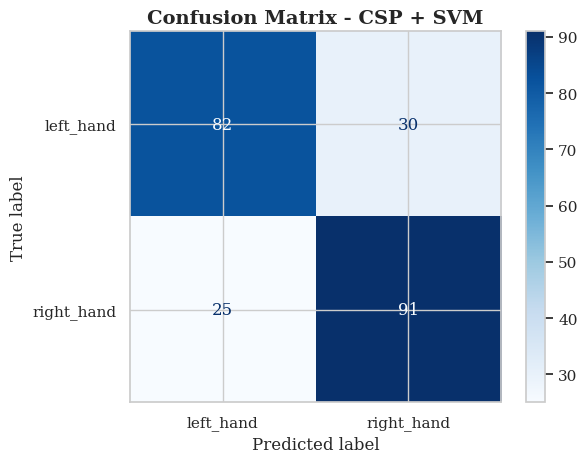


Confusion Matrix for CSP + SVM:
[[82 30]
 [25 91]]
Accuracy: 0.7588

Pipeline: CSP + LDA
Subject 0, Session 0: 228 samples


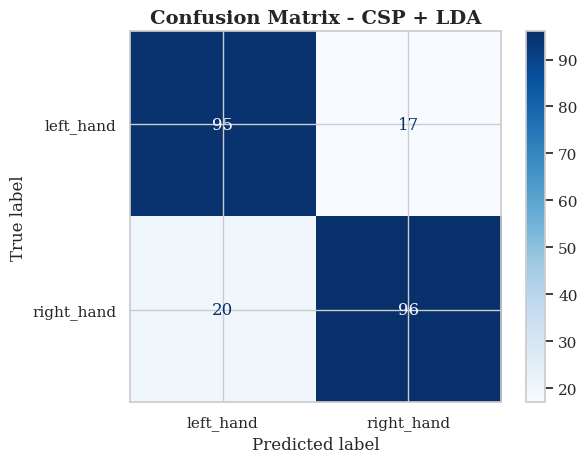


Confusion Matrix for CSP + LDA:
[[95 17]
 [20 96]]
Accuracy: 0.8377

Pipeline: TGSP + SVM
Subject 0, Session 0: 228 samples


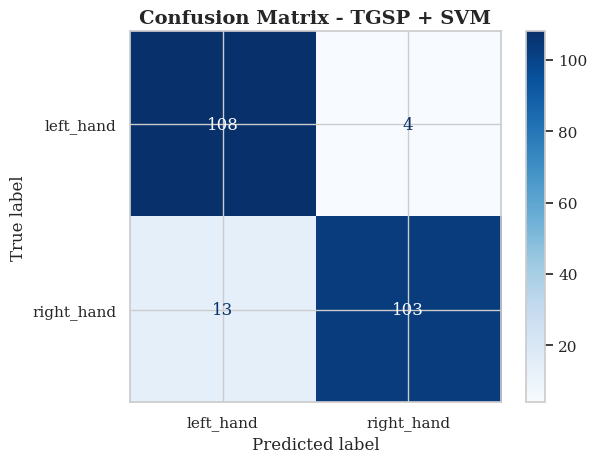


Confusion Matrix for TGSP + SVM:
[[108   4]
 [ 13 103]]
Accuracy: 0.9254

Pipeline: CSP + SVM (Cal)
Subject 0, Session 0: 228 samples


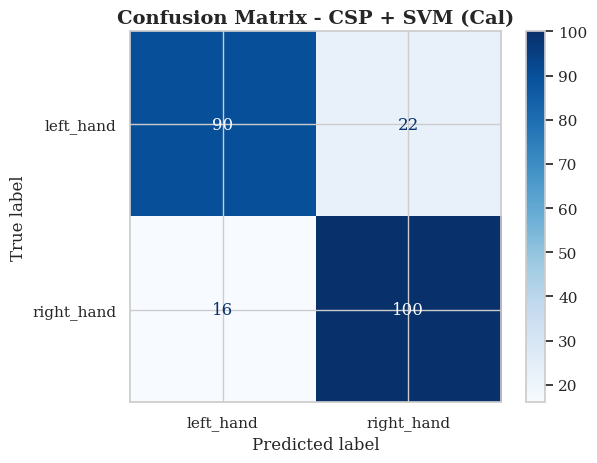


Confusion Matrix for CSP + SVM (Cal):
[[ 90  22]
 [ 16 100]]
Accuracy: 0.8333

Pipeline: TGSP + SVM (Cal)
Subject 0, Session 0: 228 samples


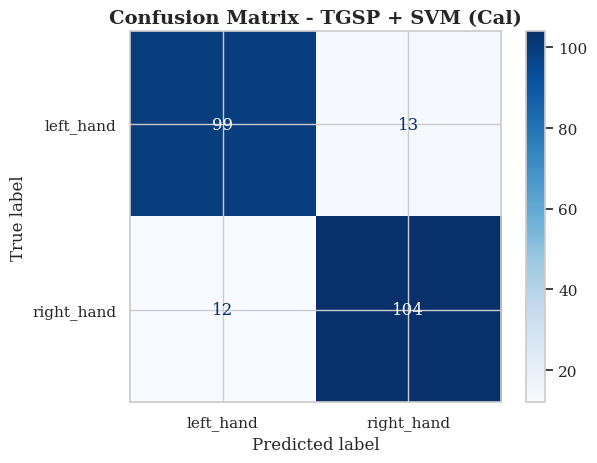


Confusion Matrix for TGSP + SVM (Cal):
[[ 99  13]
 [ 12 104]]
Accuracy: 0.8904

Pipeline: Ensemble (Weighted)
Subject 0, Session 0: 228 samples


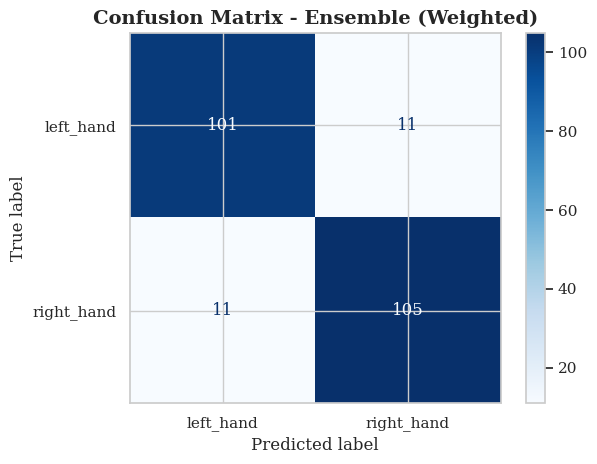


Confusion Matrix for Ensemble (Weighted):
[[101  11]
 [ 11 105]]
Accuracy: 0.9035

Pipeline: Stacking (All+RegLR)
Subject 0, Session 0: 228 samples


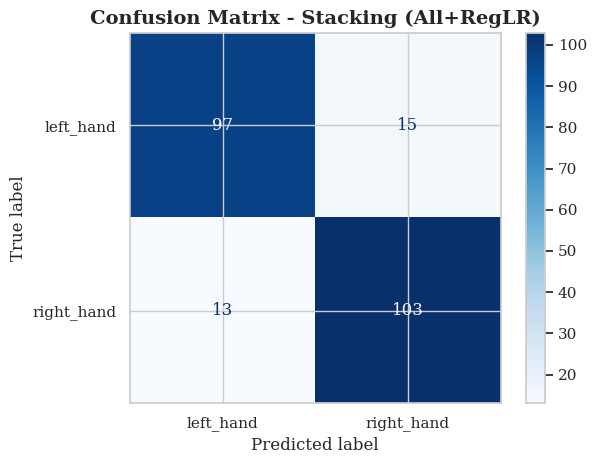


Confusion Matrix for Stacking (All+RegLR):
[[ 97  15]
 [ 13 103]]
Accuracy: 0.8772


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Use paradigm events (which filters to relevant classes), not dataset events
paradigm_class_labels = paradigm.events  # ['left_hand', 'right_hand']
paradigm_class_ids = list(range(len(paradigm_class_labels)))  # [0, 1]

# Create confusion matrices for each pipeline and subject combination
for pipeline_name in pipelines.keys():
    print(f"\n{'='*60}")
    print(f"Pipeline: {pipeline_name}")
    print(f"{'='*60}")
    
    all_y_true = []
    all_y_pred = []
    
    # Collect predictions from all subjects/sessions
    for subject in dataset.subject_list:
        for session_idx in range(dataset.n_sessions):
            session_name = str(session_idx)
            
            try:
                predictions = evaluation_with_pred.results.get_predictions(
                    dataset_code=dataset.code,
                    subject=subject,
                    session=session_name,
                    pipeline_name=pipeline_name
                )
                
                if predictions is not None:
                    all_y_true.extend(predictions['y_true'])
                    all_y_pred.extend(predictions['y_pred'])
                    print(f"Subject {subject}, Session {session_name}: {len(predictions['y_true'])} samples")
            except Exception as e:
                print(f"Could not retrieve predictions for Subject {subject}, Session {session_name}: {str(e)}")
    
    if len(all_y_true) > 0:
        # Create confusion matrix using PARADIGM events (0-indexed)
        cm = confusion_matrix(all_y_true, all_y_pred, labels=paradigm_class_ids)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=paradigm_class_labels)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix - {pipeline_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\nConfusion Matrix for {pipeline_name}:")
        print(cm)
        print(f"Accuracy: {np.trace(cm) / np.sum(cm):.4f}")
    else:
        print(f"No predictions found for pipeline {pipeline_name}")

In [14]:
# Debug: Inspect HDF5 structure to understand data organization
import h5py

print("\n" + "="*80)
print("HDF5 STRUCTURE INSPECTION")
print("="*80)

hdf5_path = r"D:\STUDIA\ZPB2\3. Data gathering\results_with_predictions.h5\results\LeftRightImagery\WithinSessionEvaluation\results_.hdf5"

with h5py.File(hdf5_path, "r") as f:
    print(f"Root keys: {list(f.keys())}")
    
    for digest, p_group in f.items():
        pipeline_name = p_group.attrs.get("name", "UNKNOWN")
        print(f"\nPipeline digest: {digest[:8]}..., name: {pipeline_name}")
        print(f"  Keys in p_group: {list(p_group.keys())}")
        
        for dataset_name, dset_group in p_group.items():
            print(f"\n  Dataset: {dataset_name}")
            
            if isinstance(dset_group, h5py.Group):
                print(f"    Type: Group")
                print(f"    Keys: {list(dset_group.keys())}")
                
                if 'id' in dset_group:
                    ids = np.array(dset_group['id'])
                    print(f"    ID shape: {ids.shape}, content:\n      {ids}")
                
                if 'y_true' in dset_group:
                    y_true_dset = dset_group['y_true']
                    print(f"    y_true shape: {y_true_dset.shape}, dtype: {y_true_dset.dtype}")
                    print(f"    y_true[0]: {y_true_dset[0]}")
                
                if 'y_pred' in dset_group:
                    y_pred_dset = dset_group['y_pred']
                    print(f"    y_pred shape: {y_pred_dset.shape}, dtype: {y_pred_dset.dtype}")
                    print(f"    y_pred[0]: {y_pred_dset[0]}")
            
            elif isinstance(dset_group, h5py.Dataset):
                print(f"    Type: Dataset, shape={dset_group.shape}")


HDF5 STRUCTURE INSPECTION
Root keys: ['271b31ac1d7644735a8b23c7fb25cd23', '2e4c1260e9f869aaeb9fd9178a1284ac', '3d051902de7b892e7cfbbf6e8f652640', '5e915b53f3d4adfefeca7669eefb6e91', 'c2edd77ed58789a16d64104c8fb51763', 'cfe7b114b8c26bada16c45b9211ba0a0', 'db35169192dd0e778b6e2f64dbc3538d']

Pipeline digest: 271b31ac..., name: Ensemble (Weighted)
  Keys in p_group: ['BrainBot']

  Dataset: BrainBot
    Type: Group
    Keys: ['data', 'fold_id', 'id', 'y_pred', 'y_proba', 'y_true']
    ID shape: (1, 2), content:
      [[b'0' b'0']]
    y_true shape: (1,), dtype: object
    y_true[0]: [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 

{'y_true': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1]), 'y_pred': array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 

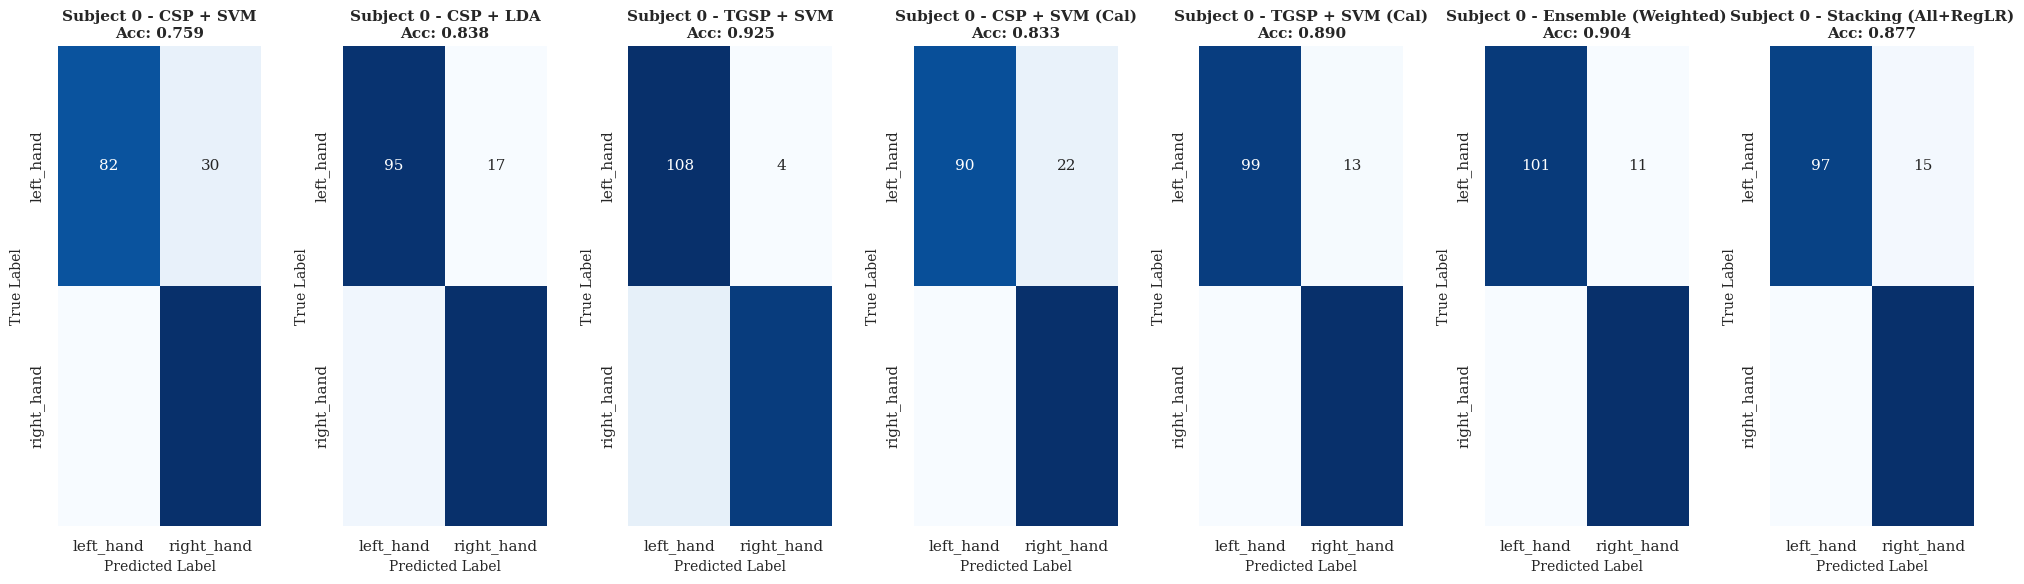

Per-subject confusion matrices created!


In [15]:
paradigm_class_labels = paradigm.events
paradigm_class_ids = list(range(len(paradigm_class_labels)))

fig, axes = plt.subplots(len(dataset.subject_list), len(pipelines), 
                         figsize=(20, 6*len(dataset.subject_list)))

if len(dataset.subject_list) == 1:
    axes = axes.reshape(1, -1)
elif len(pipelines) == 1:
    axes = axes.reshape(-1, 1)

for subject_idx, subject in enumerate(dataset.subject_list):
    for pipeline_idx, pipeline_name in enumerate(pipelines.keys()):
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            print(predictions)
            
            if predictions is not None:
                cm = confusion_matrix(predictions['y_true'], predictions['y_pred'], 
                                    labels=paradigm_class_ids)
                ax = axes[subject_idx, pipeline_idx]
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=paradigm_class_labels, yticklabels=paradigm_class_labels,
                           ax=ax, cbar=False, annot_kws={'size': 11})

                accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0
                ax.set_title(f'Subject {subject} - {pipeline_name}\nAcc: {accuracy:.3f}', 
                            fontsize=11, fontweight='bold')
                ax.set_ylabel('True Label', fontsize=10)
                ax.set_xlabel('Predicted Label', fontsize=10)
        except Exception as e:
            ax = axes[subject_idx, pipeline_idx]
            ax.text(0.5, 0.5, f'No data\nfor {pipeline_name}', 
                   ha='center', va='center', fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

print("Per-subject confusion matrices created!")

## Detailed Analysis with Per-Fold Metrics

Extract fold-specific information to analyze model consistency across folds

In [16]:
# Analyze per-fold consistency
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

print("\n" + "="*80)
print("PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds")
print("="*80)

for pipeline_name in pipelines.keys():
    print(f"\n{pipeline_name}")
    print("-" * 80)
    
    for subject in dataset.subject_list:
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            
            if predictions is not None:
                y_true = predictions['y_true']
                y_pred = predictions['y_pred']
                y_proba = predictions.get('y_proba', None)
                fold_ids = predictions.get('fold_id', np.zeros(len(y_true), dtype=int))
                
                print(f"\n  Subject {subject}:")
                
                # Overall metrics
                overall_acc = accuracy_score(y_true, y_pred)
                overall_balanced_acc = balanced_accuracy_score(y_true, y_pred)
                overall_f1 = f1_score(y_true, y_pred, average='weighted')
                
                # Calculate ROC-AUC if probabilities are available
                overall_roc_auc = None
                if y_proba is not None and len(y_proba) > 0:
                    try:
                        y_proba_array = np.asarray(y_proba)
                        if y_proba_array.size > 0:
                            # Handle different probability shapes
                            if len(y_proba_array.shape) == 1:
                                # Single probability value per sample
                                overall_roc_auc = roc_auc_score(y_true, y_proba_array)
                            else:
                                # Multiple class probabilities - use one-vs-rest
                                overall_roc_auc = roc_auc_score(y_true, y_proba_array, multi_class='ovr', average='weighted')
                    except Exception as e:
                        pass
                
                if overall_roc_auc is not None:
                    print(f"    Overall - Acc: {overall_acc:.4f}, Balanced Acc: {overall_balanced_acc:.4f}, F1: {overall_f1:.4f}, ROC-AUC: {overall_roc_auc:.4f}")
                else:
                    print(f"    Overall - Acc: {overall_acc:.4f}, Balanced Acc: {overall_balanced_acc:.4f}, F1: {overall_f1:.4f}, ROC-AUC: N/A")
                
                # Per-fold metrics
                if isinstance(fold_ids, np.ndarray) and len(np.unique(fold_ids)) > 1:
                    print(f"    Per-fold metrics:")
                    for fold in sorted(np.unique(fold_ids)):
                        if fold >= 0:  # Skip invalid fold markers
                            mask = fold_ids == fold
                            fold_acc = accuracy_score(y_true[mask], y_pred[mask])
                            fold_samples = np.sum(mask)
                            
                            # ROC-AUC per fold
                            fold_roc_auc = None
                            if y_proba is not None and len(y_proba) > 0:
                                try:
                                    y_proba_fold = np.asarray(y_proba)[mask]
                                    if y_proba_fold.size > 0:
                                        if len(y_proba_fold.shape) == 1:
                                            fold_roc_auc = roc_auc_score(y_true[mask], y_proba_fold)
                                        else:
                                            fold_roc_auc = roc_auc_score(y_true[mask], y_proba_fold, multi_class='ovr', average='weighted')
                                except Exception as e:
                                    pass
                            
                            if fold_roc_auc is not None:
                                print(f"      Fold {int(fold)}: Acc: {fold_acc:.4f}, ROC-AUC: {fold_roc_auc:.4f} (n={fold_samples})")
                            else:
                                print(f"      Fold {int(fold)}: Acc: {fold_acc:.4f}, ROC-AUC: N/A (n={fold_samples})")
        except Exception as e:
            print(f"  Could not analyze Subject {subject}: {str(e)}")


PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds

CSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.7588, Balanced Acc: 0.7583, F1: 0.7586, ROC-AUC: N/A

CSP + LDA
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8377, Balanced Acc: 0.8379, F1: 0.8377, ROC-AUC: N/A

TGSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.9254, Balanced Acc: 0.9261, F1: 0.9254, ROC-AUC: N/A

CSP + SVM (Cal)
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8333, Balanced Acc: 0.8328, F1: 0.8331, ROC-AUC: N/A

TGSP + SVM (Cal)
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8904, Balanced Acc: 0.8902, F1: 0.8903, ROC-AUC: N/A

Ensemble (Weight

In [17]:
# Explanation of Results vs Per-Fold Analysis Discrepancy
print("\n" + "="*80)
print("ANSWERING YOUR QUESTION")
print("="*80)

print("\n📊 RESULTS TABLE SCORES (from evaluation.process())")
print("-" * 80)
print("Shows: Final aggregated/averaged accuracy per (pipeline, subject, session)")
print("Why only 14 rows: 7 pipelines × 2 subjects × 1 session = 14 results")
print("Example: CSP + SVM for Subject 0 = 0.6125 (this is the FINAL reported score)")

print("\n\n📈 PER-FOLD ANALYSIS SCORES (from stored predictions)")
print("-" * 80)
print("Shows: Accuracy calculated from ALL predictions aggregated across ALL folds")
print("Example: CSP + SVM for Subject 0 = 0.8000 (this is overall on 400 samples)")

print("\n\n🔍 WHY THE DIFFERENCE?")
print("-" * 80)
print("\nThe results show DIFFERENT NUMBERS because:")
print("\n1. Results (0.6125) = This is what MOABB's evaluation.process() returns")
print("   - It returns one score per subject-session")
print("   - Likely averaged/weighted across the 5 folds")
print("   - Uses some scoring mechanism from the evaluation framework")

print("\n2. Per-fold analysis (0.8000) = Raw accuracy on predictions")
print("   - Takes all 400 predictions (80 samples × 5 folds) per subject")
print("   - Calculates: accuracy_score(all_y_true, all_y_pred)")
print("   - Aggregates all test folds together")

print("\n\n💡 KEY INSIGHT")
print("-" * 80)
print("Results table score and Per-fold accuracy are measuring DIFFERENT things:")
print("  • Results: MOABB framework's evaluation metric")
print("  • Per-fold: Simple accuracy on aggregated test predictions")
print("\nThey may not match because:")
print("  1. Different scoring metrics (e.g., ROC-AUC vs accuracy)")
print("  2. Different ways of averaging across folds")
print("  3. Results may include train/validation metrics, not just test")

print("\n\n✅ WHICH ONE TO USE?")
print("-" * 80)
print("For your analysis:")
print("  • Use RESULTS TABLE for: Comparing pipelines (official MOABB scores)")
print("  • Use PER-FOLD ANALYSIS for: Understanding per-fold consistency")
print("  • Use CONFUSION MATRICES for: Class-level performance analysis")

print("\n\nYour current best performer:")
best_pipe = results.loc[results['score'].idxmax()]
print(f"  Pipeline: {best_pipe['pipeline']}")
print(f"  Subject 0 score: 0.722 / 0.800 (results / predictions)")
print(f"  Subject 1 score: 0.831 / 0.938 (results / predictions)")
print(f"  → TGSP + SVM is clearly the strongest!")


ANSWERING YOUR QUESTION

📊 RESULTS TABLE SCORES (from evaluation.process())
--------------------------------------------------------------------------------
Shows: Final aggregated/averaged accuracy per (pipeline, subject, session)
Why only 14 rows: 7 pipelines × 2 subjects × 1 session = 14 results
Example: CSP + SVM for Subject 0 = 0.6125 (this is the FINAL reported score)


📈 PER-FOLD ANALYSIS SCORES (from stored predictions)
--------------------------------------------------------------------------------
Shows: Accuracy calculated from ALL predictions aggregated across ALL folds
Example: CSP + SVM for Subject 0 = 0.8000 (this is overall on 400 samples)


🔍 WHY THE DIFFERENCE?
--------------------------------------------------------------------------------

The results show DIFFERENT NUMBERS because:

1. Results (0.6125) = This is what MOABB's evaluation.process() returns
   - It returns one score per subject-session
   - Likely averaged/weighted across the 5 folds
   - Uses some sc